## Preprocesado

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/reviews_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33754 entries, 0 to 33753
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        33754 non-null  object 
 1   review/score              33754 non-null  float64
 2   review/text               33754 non-null  int64  
 3   Title                     33754 non-null  object 
 4   authors                   33754 non-null  object 
 5   publisher                 33754 non-null  object 
 6   publishedDate             33754 non-null  int64  
 7   categories                33754 non-null  object 
 8   Price                     33754 non-null  float64
 9   conteo                    33754 non-null  int64  
 10  review_helpfulness_up     33754 non-null  int64  
 11  review_helpfulness_total  33754 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 3.1+ MB


In [3]:
df.head(3)

,Id,review/score,review/text,Title,authors,publisher,publishedDate,categories,Price,conteo,review_helpfulness_up,review_helpfulness_total
0,0764229893,5.0,520,Gods and Kings (Chronicles of the Kings #1),Lynn Austin,Bethany House Publishers,2005,Fiction,10.19,315,0,0
1,0764229893,5.0,408,Gods and Kings (Chronicles of the Kings #1),Lynn Austin,Bethany House Publishers,2005,Fiction,10.19,315,0,0
2,0764229893,5.0,250,Gods and Kings (Chronicles of the Kings #1),Lynn Austin,Bethany House Publishers,2005,Fiction,10.19,315,0,0


### Preprocesado para Precio

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

# preprocesado para Precio
pipeline_price = Pipeline([
    (
        'onehot-log',
        ColumnTransformer(
            transformers=[
                (
                    'onehot',
                    OneHotEncoder(
                        sparse_output=False, 
                        dtype=np.uint8, 
                        handle_unknown='ignore'
                        ),
                        ['authors', 'publisher', 'categories']
                ),
                (
                    'log',
                    FunctionTransformer(np.log1p),
                    ['review/text','review_helpfulness_up', 'review_helpfulness_total']
                ),
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'z-score',
        ColumnTransformer(
            transformers=[
                (
                    'z-score',
                    StandardScaler(),
                    ['review/text','review/score', 'conteo', 'review_helpfulness_up', 'review_helpfulness_total', 'publishedDate']
                ),
                (
                    'drop_id_title',
                    'drop',
                    ['Id', 'Title']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    )
])

df_cod_price = pipeline_price.fit_transform(df)

d:\Python\Python310\venvs\py310_iar\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [5]:
df_cod_price.head(5)

,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,authors_Arlie Russell Hochschild,authors_Arthur Pike & David Pike,authors_Ashley Audrain,authors_Ben Mezrich,...,categories_Juvenile Fiction,categories_Juvenile Nonfiction,categories_Performing Arts,categories_Political Science,categories_Psychology,categories_Religion,categories_Social Science,categories_True Crime,categories_Young Adult Fiction,Price
0,0.258933,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.19
1,0.006045,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.19
2,-0.504113,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.19
3,-1.673016,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.19
4,-0.171757,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.19


### Preprocesado para Autores

In [6]:
from sklearn.preprocessing import OrdinalEncoder

autores = df['authors'].unique()
pipeline_authors = Pipeline([
    (
        'one-hot-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'onehot',
                    OneHotEncoder(
                        sparse_output=False, 
                        dtype=np.uint8, 
                        handle_unknown='ignore'
                        ),
                        ['publisher', 'categories']
                ),
                (
                    'log',
                    FunctionTransformer(np.log1p),
                    ['review/text','review_helpfulness_up', 'review_helpfulness_total']
                ),
                (
                    'ordinal',
                    OrdinalEncoder(
                        dtype=np.int64,
                        categories=[autores]
                    ),
                    ['authors']
                ),
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'z-score-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'z-score',
                    StandardScaler(),
                    ['review/text', 'Price','review/score', 'conteo', 'review_helpfulness_up', 'review_helpfulness_total', 'publishedDate']
                ),
                (
                    'drop_id_title',
                    'drop',
                    ['Id', 'Title']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    )
])

df_cod_authors = pipeline_authors.fit_transform(df)

d:\Python\Python310\venvs\py310_iar\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [7]:
df_cod_authors.head(5)

,review/text,Price,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,publisher_Ags Pub,publisher_Amsterdam University Press,publisher_Anchor Canada,...,categories_Juvenile Fiction,categories_Juvenile Nonfiction,categories_Performing Arts,categories_Political Science,categories_Psychology,categories_Religion,categories_Social Science,categories_True Crime,categories_Young Adult Fiction,authors
0,0.258933,-0.523355,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.006045,-0.523355,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.504113,-0.523355,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.673016,-0.523355,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.171757,-0.523355,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preprocesado para Rating

In [8]:
pipeline_rating = Pipeline([
    (
        'one-hot-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'onehot',
                    OneHotEncoder(
                        sparse_output=False, 
                        dtype=np.uint8, 
                        handle_unknown='ignore'
                        ),
                        ['authors', 'publisher', 'categories']
                ),
                (
                    'log',
                    FunctionTransformer(np.log1p),
                    ['review/text','review_helpfulness_up', 'review_helpfulness_total']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'z-score-transformer',
        ColumnTransformer(
            transformers=[
                (
                    'z-score',
                    StandardScaler(),
                    ['review/text', 'Price', 'conteo', 'review_helpfulness_up', 'review_helpfulness_total', 'publishedDate']
                ),
                (
                    'drop_id_title',
                    'drop',
                    ['Id', 'Title']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    ),
    (
        'rating-to-int',
        ColumnTransformer(
            transformers=[
                (
                    'rating-to-int',
                     FunctionTransformer(lambda x: x.astype(int), validate=False),
                    ['review/score']
                )
            ],
            remainder='passthrough',
            verbose_feature_names_out=False
        ).set_output(transform='pandas')
    )

])

df_cod_rating = pipeline_rating.fit_transform(df)

d:\Python\Python310\venvs\py310_iar\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [9]:
df_cod_rating.head(5)

,review/score,review/text,Price,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,authors_Arlie Russell Hochschild,authors_Arthur Pike & David Pike,authors_Ashley Audrain,...,categories_Humor,categories_Juvenile Fiction,categories_Juvenile Nonfiction,categories_Performing Arts,categories_Political Science,categories_Psychology,categories_Religion,categories_Social Science,categories_True Crime,categories_Young Adult Fiction
0,5,0.258933,-0.523355,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0.006045,-0.523355,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,-0.504113,-0.523355,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,-1.673016,-0.523355,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,-0.171757,-0.523355,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_cod_rating.dtypes

review/score                        int32
review/text                       float64
Price                             float64
conteo                            float64
review_helpfulness_up             float64
                                   ...   
categories_Psychology               uint8
categories_Religion                 uint8
categories_Social Science           uint8
categories_True Crime               uint8
categories_Young Adult Fiction      uint8
Length: 132, dtype: object

In [11]:
clases_rating = df_cod_rating['review/score'].unique()
clases_rating

array([5, 4, 2, 3, 1])

## Separacion de los datos de entrenamiento

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import time

### Separacion para Hipotesis Precio

In [13]:
df_price_train, df_price_val = train_test_split(df_cod_price, test_size=0.25, random_state=42, stratify=df_cod_price['Price'])

In [14]:
X_price_train = df_price_train.drop(columns='Price')
Y_price_train = df_price_train['Price']

X_price_val = df_price_val.drop(columns='Price')
Y_price_val = df_price_val['Price']

### Separacion para Hipotesis Autores

In [15]:
df_authors_train, df_authors_val = train_test_split(df_cod_authors, test_size=0.25, random_state=42, stratify=df_cod_authors['authors'])

In [16]:
X_authors_train = df_authors_train.drop(columns='authors')
Y_authors_train = df_authors_train['authors']

X_authors_val = df_authors_val.drop(columns='authors')
Y_authors_val = df_authors_val['authors']

In [17]:
# Suponiendo que 'autores' contiene las etiquetas de autores
autores = df['authors'].unique()

# Revertir la codificación ordinal
columnas_codificadas = ['authors']  # Ajusta las columnas según tu configuración
pipeline_authors_ordinal = pipeline_authors.named_steps['one-hot-transformer']

# Obtener las transformaciones inversas para las columnas codificadas
transformaciones_inversas = pipeline_authors_ordinal.transformers_
ordinal_encoder = transformaciones_inversas[2][1]
ordinal_encoder.categories

[array(['Lynn Austin', 'Sherry Argov', 'Beth Hensperger', 'Bonnie Dobkin',
        'Shaunti Feldhahn', 'Benjamin Hoff', 'William Queen',
        'Arthur Pike & David Pike', 'Ben Mezrich', 'Oscar Wilde',
        'Gary Chapman', 'Charlotte Brontë', 'Bill Wiese', 'Steve Krug',
        'Kent Haruf', 'Ernest J. Gaines', 'Brandon Sanderson',
        'Lewis Carroll', 'Charles Dickens', 'Stephen Crane',
        'Kresley Cole', 'Thomas Harris', 'Herbert O. Yardley',
        'Shel Silverstein', 'Jonah Goldberg', 'Nora Ephron', 'Mark Steyn',
        'Nicholas Sparks', 'Diana Gabaldon', 'Michael J. Fox',
        'Thomas Hardy', 'Jerry Spinelli', 'Jane Austen', 'Ursula Hegi',
        'Terry Goodkind', 'Michael Shaara', 'Arlie Russell Hochschild',
        'Tomi Adeyemi', 'Howard Zinn', 'Julia Quinn', 'Norton Juster',
        'Blake Snyder', 'Christopher Paolini', 'Harriet Jacobs',
        'Megan McCafferty', 'Chuck Palahniuk', 'Robert Louis Stevenson',
        'Patricia Daniels Cornwell', 'Ashley Au

In [18]:
autores_originales = {}
for i, autor in enumerate(ordinal_encoder.categories[0]):
    autores_originales[i] = autor

autores_originales

{0: 'Lynn Austin',
 1: 'Sherry Argov',
 2: 'Beth Hensperger',
 3: 'Bonnie Dobkin',
 4: 'Shaunti Feldhahn',
 5: 'Benjamin Hoff',
 6: 'William Queen',
 7: 'Arthur Pike & David Pike',
 8: 'Ben Mezrich',
 9: 'Oscar Wilde',
 10: 'Gary Chapman',
 11: 'Charlotte Brontë',
 12: 'Bill Wiese',
 13: 'Steve Krug',
 14: 'Kent Haruf',
 15: 'Ernest J. Gaines',
 16: 'Brandon Sanderson',
 17: 'Lewis Carroll',
 18: 'Charles Dickens',
 19: 'Stephen Crane',
 20: 'Kresley Cole',
 21: 'Thomas Harris',
 22: 'Herbert O. Yardley',
 23: 'Shel Silverstein',
 24: 'Jonah Goldberg',
 25: 'Nora Ephron',
 26: 'Mark Steyn',
 27: 'Nicholas Sparks',
 28: 'Diana Gabaldon',
 29: 'Michael J. Fox',
 30: 'Thomas Hardy',
 31: 'Jerry Spinelli',
 32: 'Jane Austen',
 33: 'Ursula Hegi',
 34: 'Terry Goodkind',
 35: 'Michael Shaara',
 36: 'Arlie Russell Hochschild',
 37: 'Tomi Adeyemi',
 38: 'Howard Zinn',
 39: 'Julia Quinn',
 40: 'Norton Juster',
 41: 'Blake Snyder',
 42: 'Christopher Paolini',
 43: 'Harriet Jacobs',
 44: 'Megan Mc

In [19]:
df_autores_numero = pd.DataFrame(list(autores_originales.items()), columns=['Codigo', 'Autor'])
df_autores_numero

,Codigo,Autor
0,0,Lynn Austin
1,1,Sherry Argov
2,2,Beth Hensperger
3,3,Bonnie Dobkin
4,4,Shaunti Feldhahn
5,5,Benjamin Hoff
6,6,William Queen
7,7,Arthur Pike & David Pike
8,8,Ben Mezrich
9,9,Oscar Wilde


### Separacion para Hipotesis Rating

In [20]:
df_rating_train, df_rating_val = train_test_split(df_cod_rating, test_size=0.25, random_state=42, stratify=df_cod_rating['review/score'])

In [21]:
X_rating_train = df_rating_train.drop(columns='review/score')
Y_rating_train = df_rating_train['review/score']

X_rating_val = df_rating_val.drop(columns='review/score')
Y_rating_val = df_rating_val['review/score']

In [22]:
clases_rating = df_rating_train['review/score'].unique()
clases_rating

array([5, 3, 1, 4, 2])

### Entrenamiento para Hipotesis Rating

In [23]:
rf_rating = RandomForestClassifier(n_estimators = 120, max_depth = 15, class_weight = 'balanced')
start = time.time()
rf_rating.fit(X_rating_train, Y_rating_train)
end = time.time()
print(f"Tiempo de entrenamiento: {end-start} segundos")

Tiempo de entrenamiento: 4.752376556396484 segundos


In [24]:
predicciones_train_rating = rf_rating.predict(X_rating_train)

In [25]:
accuracy_train_rating = accuracy_score(Y_rating_train, predicciones_train_rating)
print(f'Exactitud en los datos de entrenamiento: {accuracy_train_rating:.2f}')

Exactitud en los datos de entrenamiento: 0.73


In [26]:
predicciones_val_rating = rf_rating.predict(X_rating_val)

In [27]:
accuracy_val_rating = accuracy_score(Y_rating_val, predicciones_val_rating)
print(f'Exactitud en los datos de validacion: {accuracy_val_rating:.2f}')

Exactitud en los datos de validacion: 0.52


### Entrenamiento clasificador para Hipotesis Autores

#### Clasificador Random Forest

In [28]:
rf_autores = RandomForestClassifier(n_estimators = 150, max_depth = 12, class_weight = 'balanced')
start = time.time()
rf_autores.fit(X_authors_train, Y_authors_train)
end = time.time()
print(f"Tiempo de entrenamiento: {end-start} segundos")

Tiempo de entrenamiento: 2.9062345027923584 segundos


In [29]:
predicciones_train_autores = rf_autores.predict(X_authors_train)

In [30]:
accuracy_train_autores = accuracy_score(Y_authors_train, predicciones_train_autores)
print(f'Exactitud en los datos de entrenamiento: {accuracy_train_autores:.2f}')

Exactitud en los datos de entrenamiento: 1.00


In [31]:
predicciones_val_autores = rf_autores.predict(X_authors_val)
accuracy_val_autores = accuracy_score(Y_authors_val, predicciones_val_autores)
print(f'Exactitud en los datos de validación: {accuracy_val_autores:.2f}')

Exactitud en los datos de validación: 1.00


In [32]:
rf_autores.feature_importances_

array([0.00117879, 0.0450807 , 0.00095055, 0.05340563, 0.00212026,
       0.00210978, 0.04232287, 0.00540869, 0.012104  , 0.01116148,
       0.01646663, 0.00790088, 0.0154708 , 0.01104008, 0.0135578 ,
       0.01624951, 0.01475905, 0.0093782 , 0.01869814, 0.01348262,
       0.01661013, 0.01175825, 0.01217659, 0.01233119, 0.01158949,
       0.01085919, 0.00670592, 0.01209632, 0.00741654, 0.01548663,
       0.01814901, 0.01403163, 0.01229985, 0.02063196, 0.01783823,
       0.01508738, 0.01621604, 0.01453483, 0.01139537, 0.01145767,
       0.01547581, 0.02030222, 0.01027655, 0.01098365, 0.01305921,
       0.01291832, 0.00979355, 0.01442221, 0.01058905, 0.01835021,
       0.01259858, 0.01079658, 0.01823169, 0.01798732, 0.00389414,
       0.01271274, 0.00796784, 0.00827852, 0.00917369, 0.0108308 ,
       0.01165723, 0.00792736, 0.00823536, 0.01346443, 0.01518867,
       0.01268135, 0.00588391, 0.0111839 , 0.00669903, 0.00678912,
       0.00980241, 0.01177118, 0.01130836, 0.01146614, 0.00858

#### Clasificador MLP para Autores

In [33]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [34]:
start = time.time()
mlp_autores = MLPClassifier(hidden_layer_sizes=(20,20,20), max_iter=400, activation='logistic', alpha=0.001,  random_state=17)
mlp_autores.fit(X_authors_train, Y_authors_train)
end = time.time()

print(f"Tiempo de entrenamiento: {end-start}")

Tiempo de entrenamiento: 33.10613298416138


In [35]:
predicciones_train_autores_mlp = mlp_autores.predict(X_authors_train)
accuracy_train_autores_mlp = accuracy_score(Y_authors_train, predicciones_train_autores_mlp)
print(f'Exactitud en los datos de entrenamiento: {accuracy_train_autores_mlp:.2f}')

Exactitud en los datos de entrenamiento: 1.00


In [36]:
from sklearn.preprocessing import LabelEncoder
df_cod_ord = df.copy()

# Lista de columnas a codificar
columnas_label = ['Title', 'authors', 'publisher', 'categories']

# Crear una instancia del codificador
label_encoder = LabelEncoder()

# Aplicar Label Encoding a cada columna
for columna in columnas_label:
    df_cod_ord[columna] = label_encoder.fit_transform(df_cod_ord[columna])

# Ver el DataFrame resultante
df_cod_ord.head()

df_cod_ord = df_cod_ord.drop(columns='Id')
correlacion_authors_ord =df_cod_ord.corrwith(df_cod_ord['authors'])
correlacion_authors_ord_df = pd.DataFrame(correlacion_authors_ord, columns=['Correlation']).sort_values('Correlation').dropna()
# Es necesario hacer la copia porque sino salta una excepción al momento de graficar
correlacion_authors_ord_df_abs = correlacion_authors_ord_df.copy()
correlacion_authors_ord_df_abs['Abs_Correlation'] =correlacion_authors_ord_df_abs['Correlation'].abs()
correlacion_authors_ord_df_abs = correlacion_authors_ord_df_abs.sort_values(by='Abs_Correlation', ascending=False)
correlacion_authors_ord_df_abs

,Correlation,Abs_Correlation
authors,1.000000,1.000000
Price,-0.280731,0.280731
conteo,0.252632,0.252632
Title,0.208383,0.208383
publishedDate,-0.161830,0.161830
publisher,-0.116467,0.116467
review/score,-0.108625,0.108625
review/text,-0.039979,0.039979
review_helpfulness_total,-0.037844,0.037844
categories,-0.035867,0.035867


In [37]:
correlacion_authors_ord_df_abs['Correlation'][1:].index.values

array(['Price', 'conteo', 'Title', 'publishedDate', 'publisher',
       'review/score', 'review/text', 'review_helpfulness_total',
       'categories', 'review_helpfulness_up'], dtype=object)

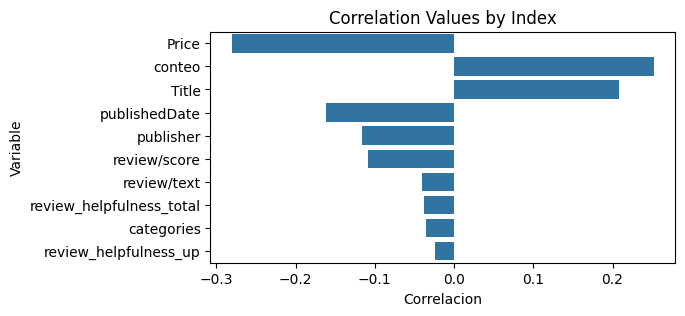

In [38]:
plt.figure(figsize=(6, 3))  # Ajusta el tamaño del gráfico si es necesario

# Utiliza sns.barplot para crear el gráfico de barras horizontales
sns.barplot(correlacion_authors_ord_df_abs['Correlation'][1:], orient="h")

# Añade etiquetas y título
plt.xlabel('Correlacion')
plt.ylabel('Variable')
plt.title('Correlation Values by Index')

# Muestra el gráfico
plt.show()

### Entrenamiento para Hipotesis Precio

In [39]:
start = time.time()
mlp_precio = MLPRegressor(hidden_layer_sizes=(20,20,20), max_iter=400, activation='logistic', alpha=0.001,  random_state=17)
mlp_precio.fit(X_price_train, Y_price_train)
end = time.time()

print(f"Tiempo de entrenamiento: {end-start}")

Tiempo de entrenamiento: 23.002431869506836


In [40]:
predicciones_train_price = mlp_precio.predict(X_price_train)
mse_price = mean_squared_error(Y_price_train, predicciones_train_price)
print(f'Error cuadrático medio: {mse_price:.2f}')

Error cuadrático medio: 0.00


## Validación de los modelos entrenados

### Validación del modelo para la hipótesis Autores

In [41]:
predicciones_val_autores = rf_autores.predict(X_authors_val)
accuracy_val_autores = accuracy_score(Y_authors_val, predicciones_val_autores)
print(f'Exactitud en los datos de validación: {accuracy_val_autores:.2f}')

Exactitud en los datos de validación: 1.00


In [42]:
confusion_authors = confusion_matrix(Y_authors_val, predicciones_val_autores)
print("Matriz de Confusión:")
print(confusion_authors)


Matriz de Confusión:
[[ 79   0   0 ...   0   0   0]
 [  0 189   0 ...   0   0   0]
 [  0   0 104 ...   0   0   0]
 ...
 [  0   0   0 ... 155   0   0]
 [  0   0   0 ...   0 196   0]
 [  0   0   0 ...   0   0 104]]


In [43]:
def plot_confusion_matrix(confusion, height, width, etiquetas_clases=None):
    plt.figure(figsize=(height, width))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

    if etiquetas_clases is not None and len(etiquetas_clases) > 0:
        plt.xticks(range(len(etiquetas_clases)), etiquetas_clases, rotation=90)
        plt.yticks(range(len(etiquetas_clases)), etiquetas_clases, rotation=0)

    # Agrega etiquetas y títulos
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.title('Matriz de Confusión')

    # Muestra el gráfico
    plt.show()

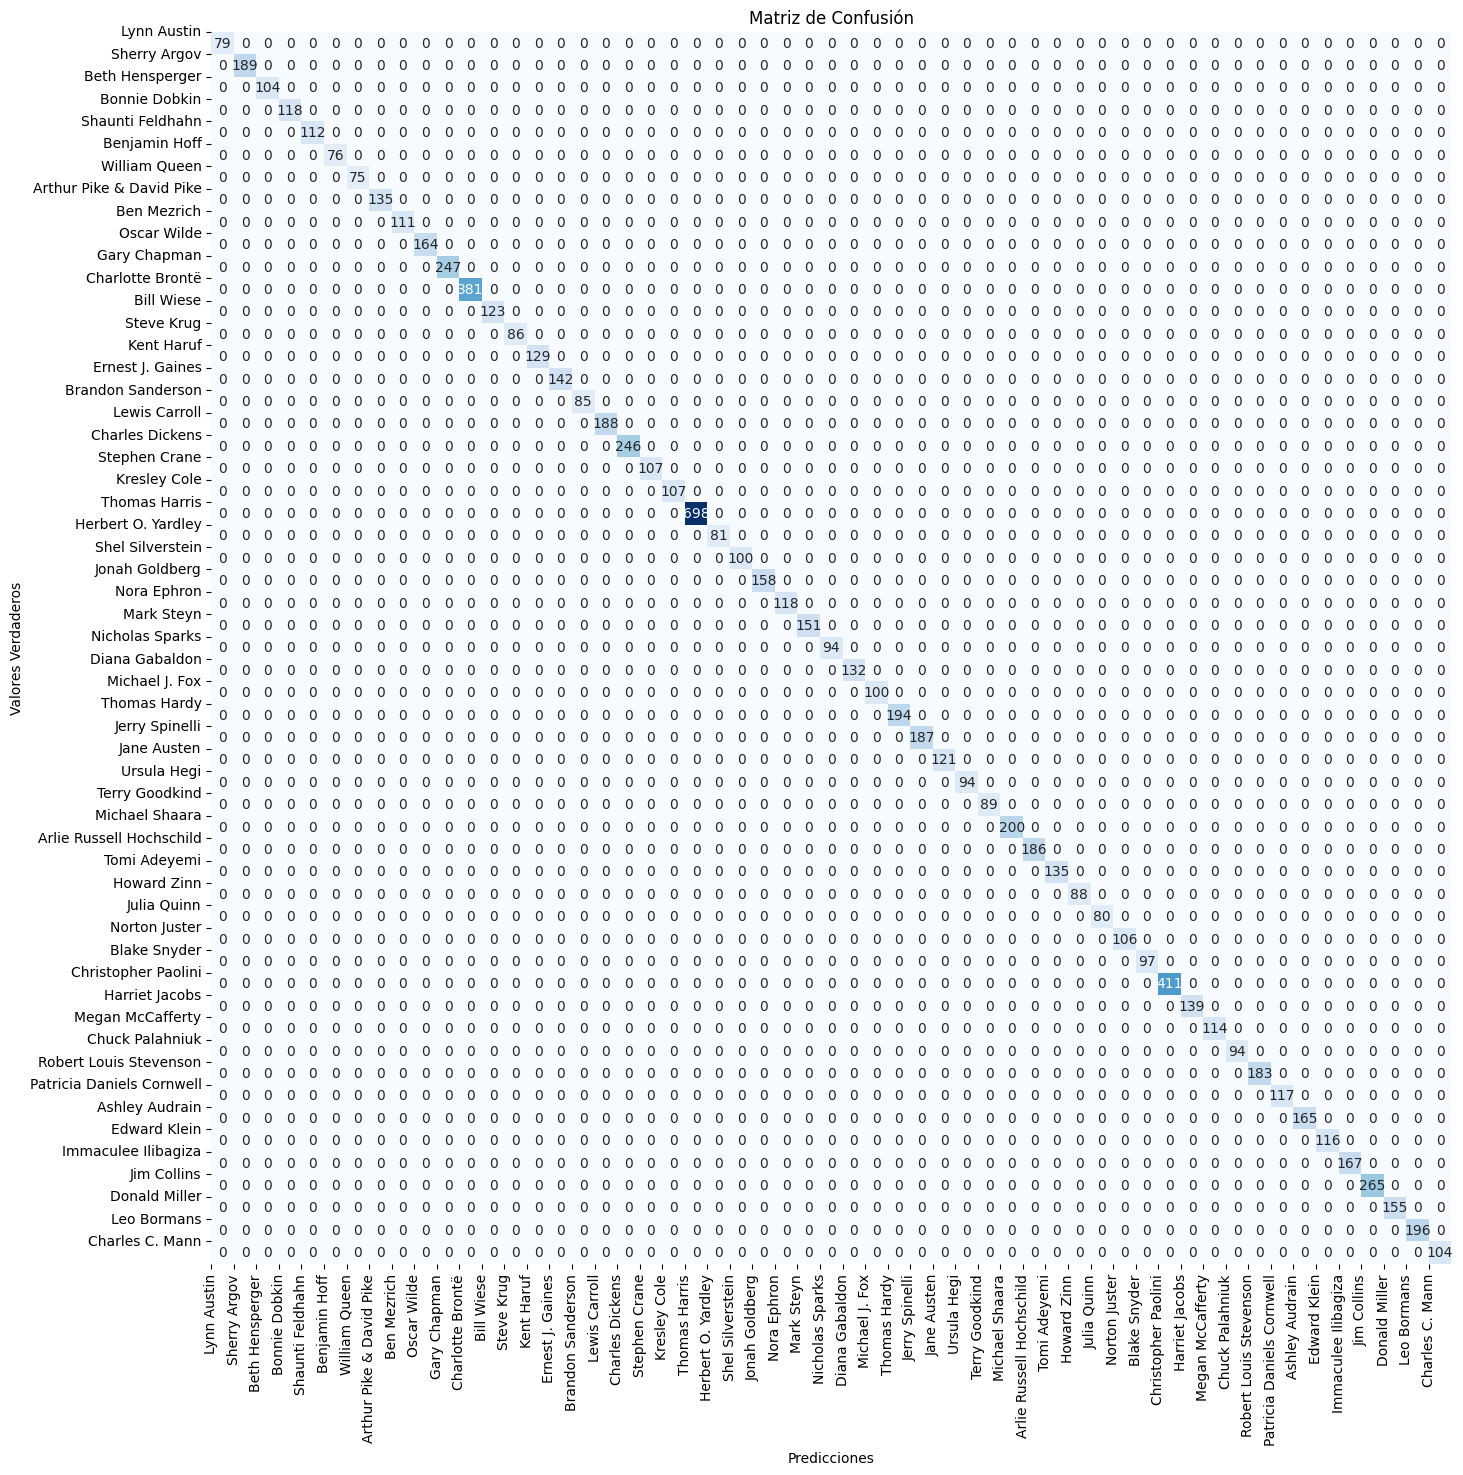

In [44]:
etiquetas_clases = df_autores_numero['Autor'].tolist()
plot_confusion_matrix(confusion_authors, 16, 16, etiquetas_clases)

### Validación del modelo para la hipótesis Rating

In [45]:
predicciones_val_rating = rf_rating.predict(X_rating_val)
accuracy_val_rating = accuracy_score(Y_rating_val, predicciones_val_rating)
print(f'Exactitud en los datos de validación: {accuracy_val_rating:.2f}')

Exactitud en los datos de validación: 0.52


In [46]:
confusion_rating = confusion_matrix(Y_rating_val, predicciones_val_rating)
print("Matriz de Confusión:")
print(confusion_rating)

Matriz de Confusión:
[[ 500  126   41   44   73]
 [ 153  118   75   65   87]
 [ 102  101  106  207  225]
 [  79  115  119  649  625]
 [ 255  176  252 1153 2993]]


In [47]:
type(clases_rating)

numpy.ndarray

In [48]:
clases_rating.shape

(5,)

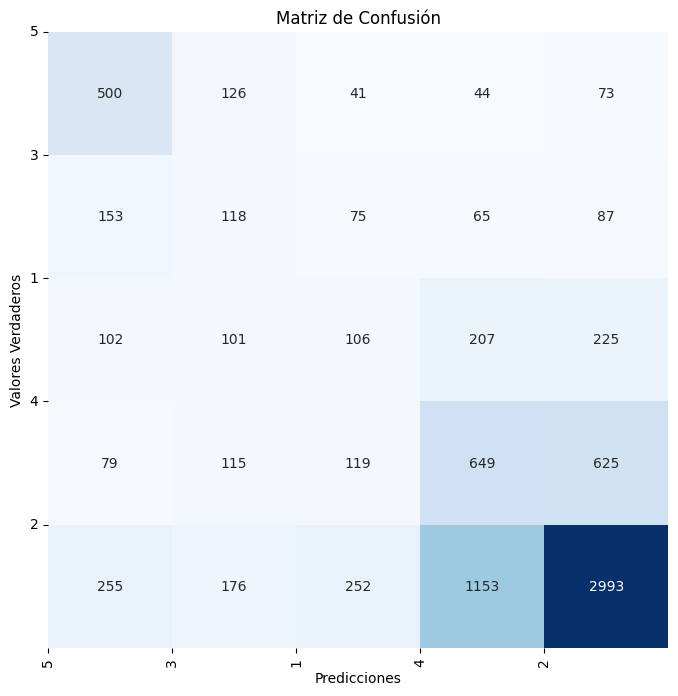

In [49]:
plot_confusion_matrix(confusion_rating, 8, 8, clases_rating.tolist())

### Validación del modelo para la hipótesis Precio

In [50]:
predicciones_val_price = mlp_precio.predict(X_price_val)
mse_price_val = mean_squared_error(Y_price_val, predicciones_val_price)
mae_price_val = mean_absolute_error(Y_price_val, predicciones_val_price)
r2_price_val = r2_score(Y_price_val, predicciones_val_price)
rmse_price_val = np.sqrt(mse_price_val)
medae_prive_val = median_absolute_error(Y_price_val, predicciones_val_price)
print(f'Error cuadrático medio: {mse_price_val:.2f}')
print(f'Error absoluto medio: {mae_price_val:.2f}')
print(f'R-squared (variabilidad capturada): {r2_price_val:.2f}')
print(f'Raiz cuadrada del MSE: {rmse_price_val:.2f}')
print(f"Error Absoluto mediano: {medae_prive_val}") #Menos suceptible a valores extremos que el MAE

Error cuadrático medio: 0.00
Error absoluto medio: 0.01
R-squared (variabilidad capturada): 1.00
Raiz cuadrada del MSE: 0.02
Error Absoluto mediano: 0.007427258126181613


In [51]:
predicciones_val_price_df = pd.DataFrame({'Predicciones': predicciones_val_price})
predicciones_val_price_concat_df = pd.concat([df_price_val.reset_index(drop=True), predicciones_val_price_df], axis=1)
predicciones_val_price_concat_df.head(10)


,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,authors_Arlie Russell Hochschild,authors_Arthur Pike & David Pike,authors_Ashley Audrain,authors_Ben Mezrich,...,categories_Juvenile Nonfiction,categories_Performing Arts,categories_Political Science,categories_Psychology,categories_Religion,categories_Social Science,categories_True Crime,categories_Young Adult Fiction,Price,Predicciones
0,-1.623252,0.694733,0.171524,-0.794639,-0.918971,0.506549,0,0,0,0,...,0,0,0,0,0,0,0,0,19.25,19.265311
1,-1.599232,-2.351318,-0.578874,0.975785,1.954333,0.095102,0,0,0,0,...,0,0,0,0,0,0,0,0,35.50,35.546535
2,1.299175,-0.828292,-0.599760,-0.109746,0.018472,-0.522070,0,0,0,0,...,0,0,0,0,0,0,0,0,13.80,13.805518
3,0.588198,0.694733,-0.599760,-0.794639,-0.918971,-0.522070,0,0,0,0,...,0,0,0,0,0,0,0,0,13.80,13.804474
4,-0.057139,0.694733,-0.786241,-0.794639,-0.918971,0.095102,0,0,0,0,...,0,0,0,0,0,0,0,0,20.86,20.809614
5,0.538756,-0.066780,-0.192486,0.290891,0.018472,0.660842,1,0,0,0,...,0,0,0,0,0,1,0,0,108.00,107.994376
6,-0.017204,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,10.19,10.184903
7,-1.394973,-0.828292,0.167049,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,5.99,5.991150
8,2.077203,0.694733,-0.108943,0.290891,0.018472,-0.419208,0,0,0,0,...,0,0,0,0,0,0,0,0,13.80,13.803593
9,-1.404784,0.694733,-0.182043,-0.794639,-0.918971,0.403687,0,0,0,0,...,0,0,0,0,0,0,0,0,4.99,4.991372


In [52]:
tamano_submuestra = 300  # Puedes ajustar esto al tamaño deseado

# Crea una submuestra aleatoria del DataFrame
submuestra_aleatoria = predicciones_val_price_concat_df.sample(n=tamano_submuestra, random_state=23)
submuestra_aleatoria

,review/text,review/score,conteo,review_helpfulness_up,review_helpfulness_total,publishedDate,authors_Arlie Russell Hochschild,authors_Arthur Pike & David Pike,authors_Ashley Audrain,authors_Ben Mezrich,...,categories_Juvenile Nonfiction,categories_Performing Arts,categories_Political Science,categories_Psychology,categories_Religion,categories_Social Science,categories_True Crime,categories_Young Adult Fiction,Price,Predicciones
4323,2.220981,0.694733,-0.680320,-0.794639,-0.918971,0.455118,0,0,0,0,...,0,0,0,0,0,0,0,0,24.15,24.167688
6495,-1.519259,0.694733,-0.182043,-0.109746,0.018472,0.403687,0,0,0,0,...,0,0,0,0,0,0,0,0,4.99,4.991565
3258,0.589661,0.694733,0.171524,0.795635,0.609932,0.506549,0,0,0,0,...,0,0,0,0,0,0,0,0,19.25,19.260031
4752,0.153517,0.694733,-0.832488,-0.794639,-0.918971,0.043671,0,0,0,0,...,0,0,0,0,0,0,0,0,10.19,10.184619
2495,1.640096,-0.066780,-0.176076,0.795635,0.454358,-0.110622,0,0,0,0,...,0,0,0,0,0,0,0,0,10.85,10.852942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,0.709636,-0.066780,-0.596777,-0.794639,-0.918971,0.197964,0,0,0,0,...,0,0,0,0,0,0,0,0,14.93,14.932462
1529,-1.114104,0.694733,0.969662,-0.794639,-0.918971,-0.573501,0,0,0,0,...,0,0,0,0,0,0,0,0,14.02,14.025157
2822,1.398760,-2.351318,-0.742978,0.290891,0.741469,0.352256,0,0,0,0,...,0,0,0,0,0,0,0,0,10.88,10.883328
287,-0.431749,0.694733,-0.404328,1.812994,1.446871,0.197964,0,0,0,0,...,0,0,1,0,0,0,0,0,18.46,18.496314
